In [4]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [5]:
df_t = load_iedb_tcellepitopes(human_only=True)

/tmp/ipykernel_33523/3096547109.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df_t = load_iedb_tcellepitopes(human_only=True)


In [6]:
df_t = df_t[(df_t['Epitope', 'Length']<13)]

In [14]:
df_t['Assay'][['Assay Group', 'Method/Technique']].value_counts().head(20)

Assay Group               Method/Technique               
IFNg release              ELISPOT                            31532
proliferation             3H-thymidine                        4485
cytotoxicity              51 chromium                         4193
qualitative binding       multimer/tetramer                   3911
IFNg release              ICS                                 2897
                          ELISA                               1736
cytotoxicity              in vitro assay                       763
dissociation constant KD  surface plasmon resonance (SPR)      481
TNFa release              ICS                                  377
IL-2 release              ELISA                                269
proliferation             CFSE                                 238
IL-4 release              ELISA                                226
IL-2 release              ICS                                  222
activation                biological activity                  206
degr

In [34]:
df_t['Assay', 'Method/Technique'].value_counts().head(10)

ELISPOT                  29634
51 chromium               3331
ICS                       3287
multimer/tetramer         2697
ELISA                     1664
in vitro assay             709
3H-thymidine               460
biological activity        313
binding assay              264
cytometric bead array      227
Name: (Assay, Method/Technique), dtype: int64

In [15]:
ks = [8, 9, 10]
host = 'Homo sapiens'
selfset = {k:set(count_kmers_proteome(human, k, clean=True)) for k in ks}

In [71]:
# only specified hosts
mask = df_t['Host', 'Name'].str.match(host, na=False)
# only epitopes of length k
#mask &= df_t['Epitope', 'Description'].apply(len)==k
# only epitopes of lengths in k
mask &= df_t['Epitope', 'Description'].apply(len).isin(ks)
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(host, na=True)
# exclude autoimmune epitopes
mask &= ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                            'Occurrence of allergy',
                                                            'Occurrence of cancer']))
df_t = df_t[mask]
# exclude rare assay types
mask = df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(5).index)
df_t_f = df_t[mask]
d0 = df_t_f['Epitope', 'Description'].apply(lambda x: max([x in self for self in selfset.values()]))

In [72]:
taxons = df_t['Epitope', 'Parent Species IRI'].apply(lambda row: row.split('_')[1])
taxons.value_counts()

10245     22308
11103      3773
10376      2680
10359      2601
12637      1606
          ...  
1639          1
170325        1
1408          1
217686        1
1809          1
Name: (Epitope, Parent Species IRI), Length: 141, dtype: int64

In [57]:
df_t_f['Epitope', 'Parent Species'].value_counts().head(20)

Vaccinia virus                    22223
Hepacivirus C                      3450
Human gammaherpesvirus 4           2442
Human betaherpesvirus 5            2309
Dengue virus                       1546
Influenza A virus                  1173
Mycobacterium tuberculosis          839
Hepatitis B virus                   780
Human orthopneumovirus              667
Human immunodeficiency virus 1      562
Alphapapillomavirus 9               464
Human betaherpesvirus 6B            398
Plasmodium falciparum               346
Trypanosoma cruzi                   266
Toxoplasma gondii                   257
Mycobacterium leprae                240
Primate T-lymphotropic virus 1      227
Human alphaherpesvirus 1            217
Human gammaherpesvirus 8            137
Human mastadenovirus C              120
Name: (Epitope, Parent Species), dtype: int64

In [46]:
df_t_f[df_t_f['Assay', 'Method/Technique']=='ELISPOT']['Assay', 'Assay Group'].value_counts()

IFNg release          29490
granzyme B release       49
IL-10 release            16
TNF release              12
IL-2 release              3
IL-4 release              1
IL-17 release             1
Name: (Assay, Assay Group), dtype: int64

In [47]:
df_t_f[d0]['Epitope', 'Parent Species'].value_counts()

Vaccinia virus                   104
Human endogenous retrovirus K     13
Human betaherpesvirus 5           10
Human betaherpesvirus 6B           3
Mycobacterium tuberculosis         2
Leishmania major                   2
Human gammaherpesvirus 8           1
Plasmodium falciparum              1
Rattus norvegicus                  1
Mus musculus                       1
Dengue virus                       1
Name: (Epitope, Parent Species), dtype: int64

In [48]:
df_t_f[d0]['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             105
Occurrence of infectious disease                                                    21
Exposure with existing immune reactivity without evidence for disease                7
Environmental exposure to endemic/ubiquitous agent without evidence for disease      4
No immunization                                                                      2
Name: (1st in vivo Process, Process Type), dtype: int64

In [49]:
pos_d0 = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_d0_count = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [50]:
pos_all = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_all_count = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [52]:
dfm = pd.merge(pos_d0, pos_all, how='inner', left_index=True, right_index=True, suffixes=['_d0', '_all'])
dfm

,Assay_d0,Assay_all
,Positive,Positive
"(Assay, Method/Technique)",,
51 chromium,0.600000,0.772289
ELISA,0.833333,0.668708
ELISPOT,0.008403,0.169857
ICS,0.666667,0.720207
multimer/tetramer,0.833333,0.893792


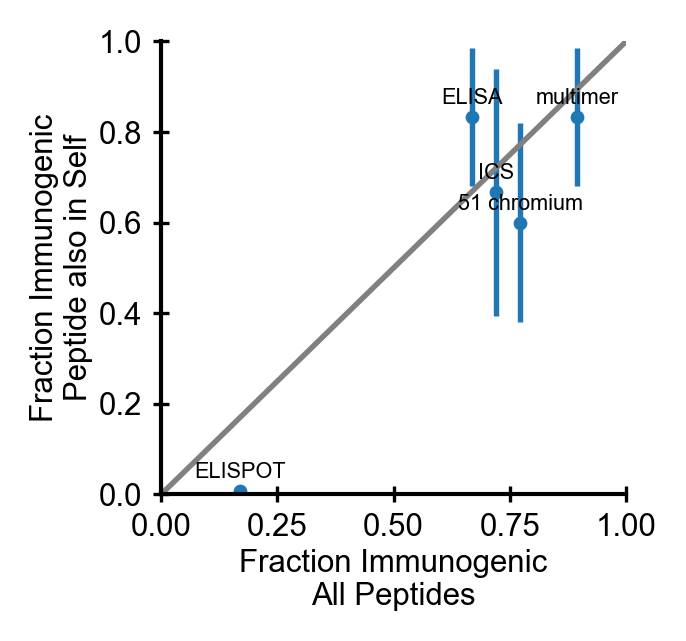

In [53]:
fig = plt.figure(figsize=(2, 2))
xs = dfm['Assay_all', 'Positive']
ys = dfm['Assay_d0', 'Positive']
counts = pos_d0_count.loc[xs.index]['Assay', 'Positive']
counts_x = pos_all_count.loc[xs.index]['Assay', 'Positive']
yerr = (ys*(1-ys)/counts)**.5
xerr = (xs*(1-xs)/counts_x)**.5
labels = dfm.index
plt.errorbar(xs, ys, yerr=yerr, xerr=xerr, fmt='o')

for x, y, label in zip(xs, ys, labels):
    plt.annotate(label.split('/')[0], (x, y+0.02),
                 ha='center', va='bottom', size='xx-small')

plt.plot([0, 1], [0, 1], '-', c='.5')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Fraction Immunogenic\nAll Peptides')
plt.ylabel('Fraction Immunogenic\nPeptide also in Self')
fig.savefig(figuredir + 'assays.svg')